<a href="https://colab.research.google.com/github/Talha-Naeem/DeepLearning-Works/blob/master/Ch8_8.8_to_8.32.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**DEEP DREAM**

In [ ]:
#8.8 Loading the pretrained Inception V3 model

In [ ]:
from keras.applications import inception_v3
from keras import backend as K
K.set_learning_phase(0)
model = inception_v3.InceptionV3(weights='imagenet',include_top=False)

In [ ]:
#8.9 Setting up the DeepDream configuration

In [ ]:
layer_contributions = {'mixed2': 0.2,'mixed3': 3.,'mixed4': 2.,'mixed5': 1.5,}

In [ ]:
#8.10 Defining the loss to be maximized

In [ ]:
layer_dict = dict([(layer.name, layer) for layer in model.layers])
loss = K.variable(0.)
for layer_name in layer_contributions:
  coeff = layer_contributions[layer_name]
  activation = layer_dict[layer_name].output
  scaling = K.prod(K.cast(K.shape(activation), 'float32'))
  loss =loss + coeff * K.sum(K.square(activation[:, 2: -2, 2: -2, :])) / scaling

In [ ]:
#8.11 Gradient-ascent process

In [ ]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
dream = model.input
grads = K.gradients(loss, dream)[0] # we use this command to solve error tf.compat.v1.disable_eager_execution()
grads /= K.maximum(K.mean(K.abs(grads)), 1e-7)
outputs = [loss, grads]
fetch_loss_and_grads = K.function([dream], outputs)
def eval_loss_and_grads(x):
  outs = fetch_loss_and_grads([x])
  loss_value = outs[0]
  grad_values = outs[1]
  return loss_value, grad_values
def gradient_ascent(x, iterations, step, max_loss=None):
  for i in range(iterations):
    loss_value, grad_values = eval_loss_and_grads(x)
    if max_loss is not None and loss_value > max_loss:
      break
    print('...Loss value at', i, ':', loss_value)
    x += step * grad_values
  return x

In [ ]:
#8.13 Auxiliary functions #this code run before 8.12 code otherwise they give error

In [ ]:
import scipy
from skimage.io import imsave # this library help us to solve image error
from keras.preprocessing import image

def resize_img(img, size):
    img = np.copy(img)
    factors = (1,
               float(size[0]) / img.shape[1],
               float(size[1]) / img.shape[2],
               1)
    return scipy.ndimage.zoom(img, factors, order=1)


def save_img(img, fname):
    pil_img = deprocess_image(np.copy(img))
    imsave(fname, pil_img)


def preprocess_image(image_path):
    # Util function to open, resize and format pictures
    # into appropriate tensors.
    img = image.load_img(image_path)
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = inception_v3.preprocess_input(img)
    return img


def deprocess_image(x):
    # Util function to convert a tensor into a valid image.
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, x.shape[2], x.shape[3]))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((x.shape[1], x.shape[2], 3))
    x /= 2.
    x += 0.5
    x *= 255.
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [ ]:
#8.12 Running gradient ascent over different successive scales

In [ ]:
from skimage.io import imsave # this library help us to solve image error
import numpy as np
step = 0.01
num_octave = 3
octave_scale = 1.4
iterations = 20
max_loss = 10.
base_image_path = '/african-lion-2888519_640.jpg'
img = preprocess_image(base_image_path)
original_shape = img.shape[1:3]
successive_shapes = [original_shape]
for i in range(1, num_octave):
  shape = tuple([int(dim / (octave_scale ** i))
    for dim in original_shape])
  successive_shapes.append(shape)
successive_shapes = successive_shapes[::-1]
original_img = np.copy(img)
shrunk_original_img = resize_img(img, successive_shapes[0])
for shape in successive_shapes:
  print('Processing image shape', shape)
  img = resize_img(img, shape)
  img = gradient_ascent(img,iterations=iterations,step=step,max_loss=max_loss)
  upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)
  same_size_original = resize_img(original_img, shape)
  lost_detail = same_size_original - upscaled_shrunk_original_img
  img += lost_detail
  shrunk_original_img = resize_img(original_img, shape)
  save_img(img, fname='dream_at_scale_' + str(shape) + '.jpg')  
save_img(img, fname='final_dream.png')

Processing image shape (242, 326)
...Loss value at 0 : 1.5654188
...Loss value at 1 : 2.2256467
...Loss value at 2 : 3.0577815
...Loss value at 3 : 3.8468838
...Loss value at 4 : 4.7185597
...Loss value at 5 : 5.5809817
...Loss value at 6 : 6.3649116
...Loss value at 7 : 7.109719
...Loss value at 8 : 7.8106422
...Loss value at 9 : 8.437675
...Loss value at 10 : 9.072323
...Loss value at 11 : 9.757698
Processing image shape (340, 457)
...Loss value at 0 : 2.9851325
...Loss value at 1 : 4.4164042
...Loss value at 2 : 5.7322464
...Loss value at 3 : 6.9090304
...Loss value at 4 : 7.86968
...Loss value at 5 : 8.838632
...Loss value at 6 : 9.71355
Processing image shape (476, 640)
...Loss value at 0 : 2.922325
...Loss value at 1 : 4.1971345
...Loss value at 2 : 5.435602
...Loss value at 3 : 6.542241
...Loss value at 4 : 7.6254816
...Loss value at 5 : 8.642268
...Loss value at 6 : 9.643346


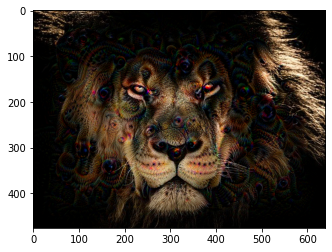

In [ ]:
from matplotlib import pyplot as plt

plt.imshow(deprocess_image(np.copy(img)))
plt.show()

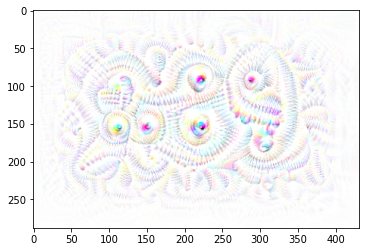

In [ ]:
from matplotlib import pyplot as plt

plt.imshow(deprocess_image(np.copy(img)))
plt.show()

**Neural Style Transfer**


In [ ]:
 #8.14 Defining initial variables

In [ ]:
from keras.preprocessing.image import load_img, img_to_array
target_image_path = '/content/[upload.wikimedia.org][38]220px-Lightmatter_elephanttrunk.jpg'
style_reference_image_path = '/african-lion-2888519_640.jpg'
width, height = load_img(target_image_path).size
img_height = 400
img_width = int(width * img_height / height)

In [ ]:
#8.15 Auxiliary functions

In [ ]:
import numpy as np
from keras.applications import vgg19
def preprocess_image(image_path):
  img = load_img(image_path, target_size=(img_height, img_width))
  img = img_to_array(img)
  img = np.expand_dims(img, axis=0)
  img = vgg19.preprocess_input(img)
  return img
def deprocess_image(x):
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = x[:, :, ::-1]
  x = np.clip(x, 0, 255).astype('uint8')
  return x

In [ ]:
#8.16 Loading the pretrained VGG19 network and applying it to the three images

In [ ]:
from keras import backend as K
target_image = K.constant(preprocess_image(target_image_path))
style_reference_image = K.constant(preprocess_image(style_reference_image_path))
combination_image = K.placeholder((1, img_height, img_width, 3))
input_tensor = K.concatenate([target_image,style_reference_image,combination_image], axis=0)
model = vgg19.VGG19(input_tensor=input_tensor,weights='imagenet',include_top=False)
print('Model loaded.')

80142336/80134624 [==============================] - 1s 0us/step
Model loaded.


In [ ]:
#8.17 Content loss

In [ ]:
def content_loss(base, combination):
  return K.sum(K.square(combination - base))

In [ ]:
#8.18 Style loss

In [ ]:
def gram_matrix(x):
  features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
  gram = K.dot(features, K.transpose(features))
  return gram
def style_loss(style, combination):
  S = gram_matrix(style)
  C = gram_matrix(combination)
  channels = 3
  size = img_height * img_width
  return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

In [ ]:
#8.19 Total variation loss

In [ ]:
def total_variation_loss(x):
  a = K.square(
    x[:, :img_height - 1, :img_width - 1, :] -
    x[:, 1:, :img_width - 1, :])
  b = K.square(
    x[:, :img_height - 1, :img_width - 1, :] -
    x[:, :img_height - 1, 1:, :])
  return K.sum(K.pow(a + b, 1.25))

In [ ]:
#8.20 Defining the final loss that you’ll minimize

In [ ]:
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
content_layer = 'block5_conv2'
style_layers = ['block1_conv1','block2_conv1','block3_conv1','block4_conv1','block5_conv1']
total_variation_weight = 1e-4
style_weight = 1.
content_weight = 0.025
loss = K.variable(0.)
layer_features = outputs_dict[content_layer]
target_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss = loss + content_weight * content_loss(target_image_features,combination_features)
for layer_name in style_layers:
  layer_features = outputs_dict[layer_name]
  style_reference_features = layer_features[1, :, :, :]
  combination_features = layer_features[2, :, :, :]
  sl = style_loss(style_reference_features, combination_features)
  loss += (style_weight / len(style_layers)) * sl
loss += total_variation_weight * total_variation_loss(combination_image)

In [ ]:
#8.21 Setting up the gradient-descent process

In [ ]:
grads = K.gradients(loss, combination_image)[0]
fetch_loss_and_grads = K.function([combination_image], [loss, grads])
class Evaluator(object):
  def __init__(self):
    self.loss_value = None
    self.grads_values = None
  def loss(self, x):
    assert self.loss_value is None
    x = x.reshape((1, img_height, img_width, 3))
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    self.loss_value = loss_value
    self.grad_values = grad_values
    return self.loss_value
  def grads(self, x):
    assert self.loss_value is not None
    grad_values = np.copy(self.grad_values)
    self.loss_value = None
    self.grad_values = None
    return grad_values
evaluator = Evaluator()

In [ ]:
#8.22 Style-transfer loop

In [ ]:
from scipy.optimize import fmin_l_bfgs_b
import time
result_prefix = 'my_result'
iterations = 20
x = preprocess_image(target_image_path)
x = x.flatten()
for i in range(iterations):
  print('Start of iteration', i)
  start_time = time.time()
  x, min_val, info = fmin_l_bfgs_b(evaluator.loss,x,fprime=evaluator.grads,maxfun=20)
  print('Current loss value:', min_val)
  img = x.copy().reshape((img_height, img_width, 3))
  img = deprocess_image(img)
  fname = result_prefix + '_at_iteration_%d.png' % i
  imsave(fname, img)
  print('Image saved as', fname)
  end_time = time.time()
  print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
Current loss value: 22197647000.0
Image saved as my_result_at_iteration_0.png
Iteration 0 completed in 467s
Start of iteration 1
Current loss value: 11504249000.0
Image saved as my_result_at_iteration_1.png
Iteration 1 completed in 459s
Start of iteration 2
Current loss value: 7918091300.0
Image saved as my_result_at_iteration_2.png
Iteration 2 completed in 462s
Start of iteration 3
Current loss value: 6219077000.0
Image saved as my_result_at_iteration_3.png
Iteration 3 completed in 461s
Start of iteration 4
Current loss value: 5221984000.0
Image saved as my_result_at_iteration_4.png
Iteration 4 completed in 459s
Start of iteration 5
Current loss value: 4648302000.0
Image saved as my_result_at_iteration_5.png
Iteration 5 completed in 463s
Start of iteration 6
Current loss value: 4265578000.0
Image saved as my_result_at_iteration_6.png
Iteration 6 completed in 460s
Start of iteration 7
Current loss value: 3974709500.0
Image saved as my_result_at_iteration_7.png
Iter

KeyboardInterrupt: ignored

In [ ]:
from google.colab import files
from io import BytesIO
from PIL import Image

uploaded = files.upload()
im = Image.open(BytesIO(uploaded['/content/my_result_at_iteration_12.png']))

KeyboardInterrupt: ignored

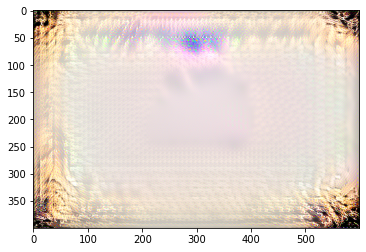

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

img = cv2.imread("/content/my_result_at_iteration_15.png")
img_cvt=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_cvt)
plt.show()

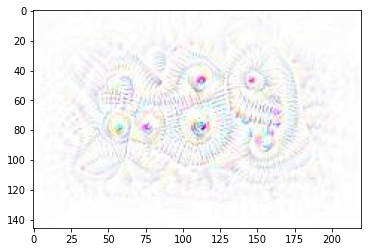

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

img = cv2.imread("/content/dream_at_scale_(146, 220).jpg")
img_cvt=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_cvt)
plt.show()

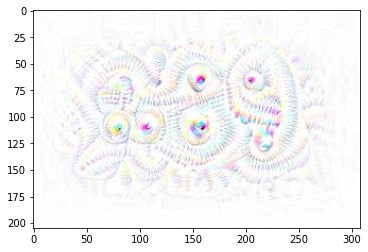

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

img = cv2.imread("/content/dream_at_scale_(205, 308).jpg")
img_cvt=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_cvt)
plt.show()

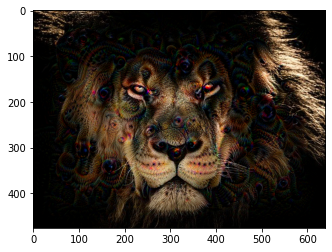

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

img = cv2.imread("/content/final_dream.png")
img_cvt=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_cvt)
plt.show()

In [ ]:
#8.23 VAE encoder network

In [ ]:
import keras
from keras import layers
from keras import backend as K
from keras.models import Model
import numpy as np
img_shape = (28, 28, 1)
batch_size = 16
latent_dim = 2
input_img = keras.Input(shape=img_shape)
x = layers.Conv2D(32, 3,padding='same', activation='relu')(input_img)
x = layers.Conv2D(64, 3,padding='same', activation='relu',strides=(2, 2))(x)
x = layers.Conv2D(64, 3,padding='same', activation='relu')(x)
x = layers.Conv2D(64, 3,padding='same', activation='relu')(x)
shape_before_flattening = K.int_shape(x)
x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)
z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

In [ ]:
#8.24 Latent-space-sampling function

In [ ]:
def sampling(args):
  z_mean, z_log_var = args
  epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),mean=0., stddev=1.)
  return z_mean + K.exp(z_log_var) * epsilon
z = layers.Lambda(sampling)([z_mean, z_log_var])

In [ ]:
#8.25 VAE decoder network, mapping latent space points to images

In [ ]:
decoder_input = layers.Input(K.int_shape(z)[1:])
x = layers.Dense(np.prod(shape_before_flattening[1:]),
activation='relu')(decoder_input)
x = layers.Reshape(shape_before_flattening[1:])(x)
x = layers.Conv2DTranspose(32, 3,padding='same',activation='relu',strides=(2, 2))(x)
x = layers.Conv2D(1, 3,padding='same',activation='sigmoid')(x)
decoder = Model(decoder_input, x)
z_decoded = decoder(z)

In [ ]:
#8.26 Custom layer used to compute the VAE loss

In [ ]:
class CustomVariationalLayer(keras.layers.Layer):
  def vae_loss(self, x, z_decoded):
    x = K.flatten(x)
    z_decoded = K.flatten(z_decoded)
    xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
    kl_loss = -5e-4 * K.mean(
      1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return K.mean(xent_loss + kl_loss)
  def call(self, inputs):
    x = inputs[0]
    z_decoded = inputs[1]
    loss = self.vae_loss(x, z_decoded)
    self.add_loss(loss, inputs=inputs)
    return x
y = CustomVariationalLayer()([input_img, z_decoded])

In [ ]:
#8.27 Training the VAE

In [ ]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers
tfk = tf.keras
tfkl = tf.keras.layers
from keras.datasets import mnist
vae = Model(input_img, y)
vae.compile(optimizer='rmsprop',loss=None)
vae.summary()
(x_train,_), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.astype('float32') / 255
x_test = x_test.reshape(x_test.shape + (1,))
vae.fit(x=x_train, y=None,shuffle=True,epochs=10,batch_size=batch_size,validation_data=(x_test,None))

Model: "functional_63"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_6[0][0]                   
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_7[0][0]                   
______________________________________________________________________________________

In [ ]:
#8.28 Sampling a grid of points from the 2D latent space and decoding them to images

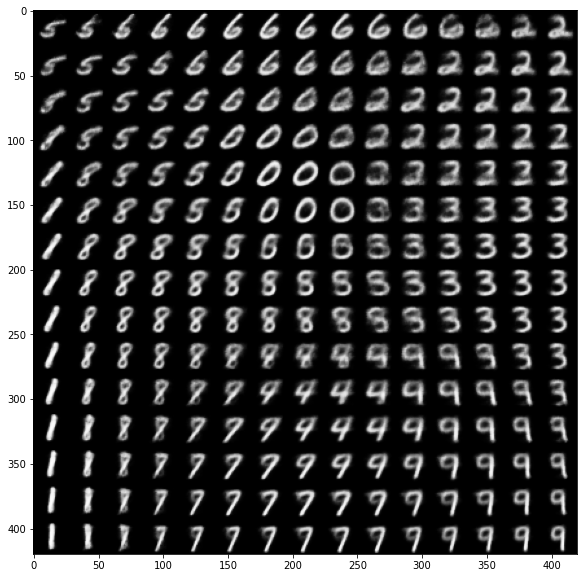

In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import norm
n = 15
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))
for i, yi in enumerate(grid_x):
  for j, xi in enumerate(grid_y):
    z_sample = np.array([[xi, yi]])
    z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
    x_decoded = decoder.predict(z_sample, batch_size=batch_size)
    digit = x_decoded[0].reshape(digit_size, digit_size)
    figure[i * digit_size: (i + 1) * digit_size,
      j * digit_size: (j + 1) * digit_size] = digit
plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

**GAN Implementation**

In [ ]:
#8.29 GAN generator network

In [ ]:
import keras
from keras import layers
import numpy as np
latent_dim = 32
height = 32
width = 32
channels = 3
generator_input = keras.Input(shape=(latent_dim,))
x = layers.Dense(128 * 16 * 16)(generator_input)
x = layers.LeakyReLU()(x)
x = layers.Reshape((16, 16, 128))(x)
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(256, 4, strides=2, padding='same')(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(channels, 7, activation='tanh', padding='same')(x)
generator = keras.models.Model(generator_input, x)
generator.summary()

Model: "functional_65"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32)]              0         
_________________________________________________________________
dense_9 (Dense)              (None, 32768)             1081344   
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32768)             0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 16, 16, 256)       819456    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 32, 32, 256)     

In [ ]:
#8.30 The GAN discriminator network

In [ ]:
discriminator_input = layers.Input(shape=(height, width, channels))
x = layers.Conv2D(128, 3)(discriminator_input)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(1, activation='sigmoid')(x)
discriminator = keras.models.Model(discriminator_input, x)
discriminator.summary()
discriminator_optimizer = keras.optimizers.RMSprop(lr=0.0008,clipvalue=1.0,decay=1e-8)
discriminator.compile(optimizer=discriminator_optimizer,loss='binary_crossentropy')

Model: "functional_67"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 30, 30, 128)       3584      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 6, 6, 128)         262272    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 6, 6, 128)       

In [ ]:
#8.31 Adversarial network

In [ ]:
discriminator.trainable = False
gan_input = keras.Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))
gan = keras.models.Model(gan_input, gan_output)
gan_optimizer = keras.optimizers.RMSprop(lr=0.0004, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')

In [ ]:
#8.32 Implementing GAN training

In [ ]:
import os
from keras.preprocessing import image
(x_train, y_train), (_, _) = keras.datasets.cifar10.load_data()
x_train = x_train[y_train.flatten() == 6]
x_train = x_train.reshape((x_train.shape[0],) +(height, width, channels)).astype('float32') / 255
iterations = 10000
batch_size = 20
save_dir = '/african-lion-2888519_640.jpg'
start = 0
for step in range(iterations):
  random_latent_vectors = np.random.normal(size=(batch_size,latent_dim))
  generated_images = generator.predict(random_latent_vectors)
  stop = start + batch_size
  real_images = x_train[start: stop]
  combined_images = np.concatenate([generated_images, real_images])
  labels = np.concatenate([np.ones((batch_size, 1)),np.zeros((batch_size, 1))])
  labels += 0.05 * np.random.random(labels.shape)
  d_loss = discriminator.train_on_batch(combined_images, labels)
  random_latent_vectors = np.random.normal(size=(batch_size,latent_dim))
  misleading_targets = np.zeros((batch_size, 1))
  a_loss = gan.train_on_batch(random_latent_vectors,misleading_targets)
  start += batch_size
  if start > len(x_train) - batch_size:
    start = 0
  if step % 100 == 0:
    gan.save_weights('gan.h5')
    print('discriminator loss:', d_loss)
    print('adversarial loss:', a_loss)
    img = image.array_to_img(generated_images[0] * 255., scale=False)
    img.save(os.path.join(save_dir,'/home' + str(step) + '.png'))
    img = image.array_to_img(real_images[0] * 255., scale=False)

discriminator loss: 0.7621938
adversarial loss: 2.0520735
discriminator loss: 0.5831523
adversarial loss: 1.4997313
discriminator loss: 0.7070794
adversarial loss: 0.7403479
discriminator loss: 0.70088094
adversarial loss: 0.75145704
discriminator loss: 0.6801307
adversarial loss: 0.7748941
discriminator loss: 0.7073753
adversarial loss: 0.7351054
discriminator loss: 0.7013674
adversarial loss: 0.7472035
discriminator loss: 0.68862
adversarial loss: 0.75268537
discriminator loss: 0.71377164
adversarial loss: 0.7251588
discriminator loss: 0.69978124
adversarial loss: 0.7792416
discriminator loss: 0.6966282
adversarial loss: 0.7994243
discriminator loss: 0.7046048
adversarial loss: 0.731417
discriminator loss: 0.69468117
adversarial loss: 0.76265097
discriminator loss: 0.69895804
adversarial loss: 0.767886


KeyboardInterrupt: ignored

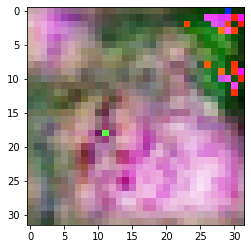

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

img = cv2.imread("/home900.png")
img_cvt=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_cvt)
plt.show()

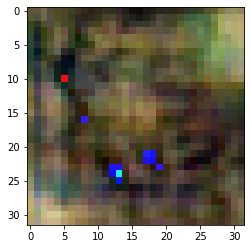

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

img = cv2.imread("/home1100.png")
img_cvt=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_cvt)
plt.show()

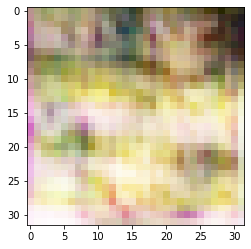

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

img = cv2.imread("/home1300.png")
img_cvt=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_cvt)
plt.show()

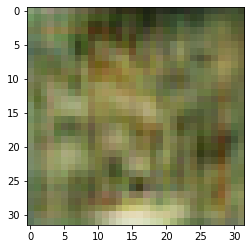

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

img = cv2.imread("/home500.png")
img_cvt=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_cvt)
plt.show()